# Klasyfikacja przy użyciu SVM (Maszyny Wektorów Nośnych)

+ Autor: **Łukasz Staniszewski**
+ Temad: **Implementacja modelu oraz metody uczącej liniowy SVM dopuszczający pomyłki, z wykorzystaniem bibliotek języka Python**
+ Zadanie: **[LINK](https://github.com/lukasz-staniszewski/ml-algorithms-scratch/blob/main/svm-classification/task_pl.pdf)**

## Import bibliotek
+ **sklearn** - zbiór danych to iris, rozdzielenie zbioru
+ **pandas** - praca nad tabelami
+ **seaborn** - wykresy
+ **numpy** - macierze, tablice
+ **math** - funkcje matematyczne

In [62]:
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import numpy as np
import math
import copy
from typing import Tuple, Dict

## Zbiór iris
+ W tym miejscu zostanie pobrany zbiór iris, jego elementy zestawione w formie tabeli:

In [63]:
iris_set = load_iris()
df_iris = pd.DataFrame(iris_set['data'], columns=iris_set.feature_names)
pd.set_option("display.max_rows", None)
df_iris.index.name = 'iris index'
df_iris['class'] = [iris_set.target_names[id] for id in iris_set.target]

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
iris index,,,,,
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Niżej wykresy (w 2D) jak wyglądają poszczególne klasy w zależności od różnych parametrów:
+ optymalizowana będzie hiperpłaszczyzna ze względu na wszystkie z 4 parametrów ($x_1, x_2, x_3, x_4$), ale nie ma możliwości zobrazowania wykresu w więcej niż 3 wymiarach, dlatego są pokazywane w dwóch.

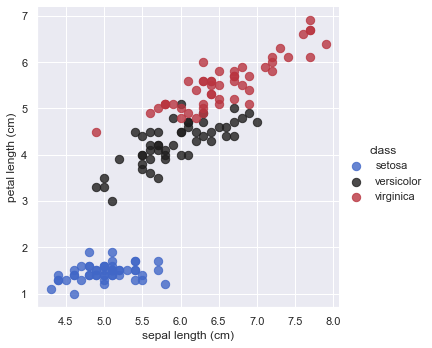

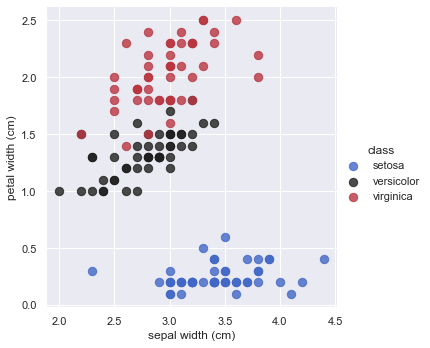

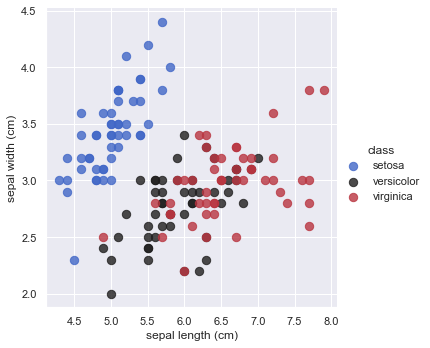

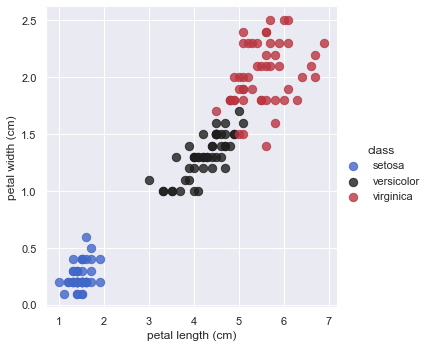

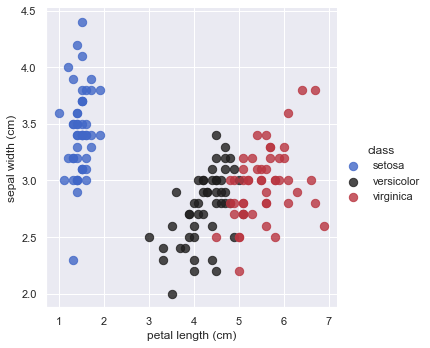

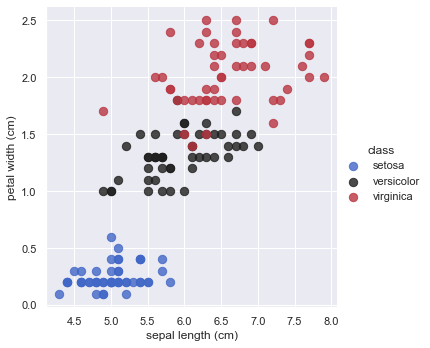

In [64]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.lmplot(x='sepal length (cm)', y='petal length (cm)', data=df_iris, hue='class', palette = "icefire", fit_reg=False, scatter_kws={"s":70})
sns.lmplot(x='sepal width (cm)', y='petal width (cm)', data=df_iris, hue='class', palette = "icefire", fit_reg=False, scatter_kws={"s":70})
sns.lmplot(x='sepal length (cm)', y='sepal width (cm)', data=df_iris, hue='class', palette = "icefire", fit_reg=False, scatter_kws={"s":70})
sns.lmplot(x='petal length (cm)', y='petal width (cm)', data=df_iris, hue='class', palette = "icefire", fit_reg=False, scatter_kws={"s":70})
sns.lmplot(x='petal length (cm)', y='sepal width (cm)', data=df_iris, hue='class', palette = "icefire", fit_reg=False, scatter_kws={"s":70})
sns.lmplot(x='sepal length (cm)', y='petal width (cm)', data=df_iris, hue='class', palette = "icefire", fit_reg=False, scatter_kws={"s":70})


## Zdefiniowanie problemu
+ Zadanie polega na znalezieniu funkcji $ f(x)={w^{T}x-b}$, która tworzy hiperpłaszczyznę zapewniającą klasyfikację (dopuszczającą pomyłki) z użyciem maszyny wektorów nośnych SVM.

+ Otrzymana funkcja powinna zapewniać jak najmniejszą liczbę pomyłek przy klasyfikowaniu elementów zbioru IRIS do odpowiedniej klasy. Klasyfikacja odbywa się poprzez zwrócenie dla danego zestawu cech ($x$) - grupy ( $ y(x) = -1 \lor y(x) = 1 $ ) do której należy za pomocą funkcji: 
$$
y(x)=
\left\{ 
\begin{array}{c}
-1\text{,} f(x)<0 \\ 
1\text{,} f(x)\geq0 \\
\end{array}
\right. 
$$

+ Aby otrzymać funkcję $f(x)$ należy znaleźć parametry $w$ i $b$, które minimalizują funkcję straty:
$$ (w,b)= \underset{w,b}{\operatorname{argmin}} \space J(w,b)$$
$$ J(w,b)=\Sigma_i \operatorname{max}\{1-f(x_i) \cdot y_i, 0\} + \lambda \cdot ||w||^2 $$

+ Aby zoptymalizować owe parametry, zastosowana zostanie **metoda gradientu prostego**, w tym celu potrzebny będzie gradient funkcji $J(w,b)$:
$$
\nabla J = 
\begin{bmatrix} 
    \partial J \over \partial w_1 \\
    ... \\ 
    \partial J \over \partial w_n \\
    \\
    \partial J \over \partial b
\end{bmatrix}
$$

+ A pochodne cząstkowe te prezentują się następująco: 
$$
{\partial J \over \partial w_i} = {\lambda \cdot 2 \cdot w_i} + \Sigma_k(1 \cdot 

\left\{ 
\begin{array}{c}
0, 1-f(x_k)y_k \leqslant 0 \\ 
-y_k \cdot x_{k[i]}, 1-f(x_k)y_k > 0 \\
\end{array}
\right. 

)
$$

$$
{\partial J \over \partial b} = \Sigma_k(1 \cdot 

\left\{ 
\begin{array}{c}
0, 1-f(x_k)y_k \leqslant 0 \\ 
y_k, 1-f(x_k)y_k > 0 \\
\end{array}
\right. 

)
$$

## Klasa SVM

In [104]:
MINIMIZER_PARAMS_DEFAULT = {
    "beta": 0.01,
    "max_steps": 10000,
    "min_epsilon": 1e-20,
}

PRED_MAPPER_PARAMS_DEFAULT = {1: 1, -1: 0}

In [123]:
class SVM:
    """Class represents SVM model."""

    def __init__(
        self,
        lambd: float,
        minimizer_params: dict = {},
        mapper_params: dict = {}
    ) -> None:
        """Class SVM constructor.
        Args:
            lambd (float): lambda penalty hiperparameter
            minimizer_params (dict, optional): parameters for gradient descent minimizer.
                Defaults to {"beta": 0.01, "max_steps": 10000, "min_epsilon": 1e-20}.
            mapper_params (dict, optional): parameters predictions mapper.
                Defaults to {1: 1, -1: 0}.
        """
        self.W = None
        self.b = None
        self.lambd = lambd
        self._set_minimizer_params(**minimizer_params)
        self._set_mapper_params(mapper_params)

    def _set_minimizer_params(self, **kwargs) -> None:
        """Function setting minimizer params."""
        self._set_beta(beta=MINIMIZER_PARAMS_DEFAULT["beta"])
        self._set_max_steps(max_steps=MINIMIZER_PARAMS_DEFAULT["max_steps"])
        self._set_min_epsilon(epsilon=MINIMIZER_PARAMS_DEFAULT["min_epsilon"])
        default_params = {
            "beta": self._set_beta,
            "max_steps": self._set_max_steps,
            "min_epsilon": self._set_min_epsilon,
        }
        for key, item in kwargs.items():
            if key not in default_params.keys():
                raise Exception(
                    "Possible keys in dict are only 'beta', 'max_steps'"
                    " and 'min_epsilon'!"
                )
            if type(item) is not int and type(item) is not float:
                raise Exception(
                    "Possible values for minimizer params dict items"
                    " are int or float!"
                )
            default_params[key](item)

    def _set_mapper_params(self, usr_mapped_params: dict) -> None:
        """Function setting mapper params.
        Args:
            usr_mapped_params (dict): params for mapper provided by user
        """
        mapper_params = copy.copy(PRED_MAPPER_PARAMS_DEFAULT)
        for key, item in usr_mapped_params.items():
            if key not in mapper_params.keys():
                raise Exception(
                    "Possible keys in dict are only 1 and -1!"
                )
            if type(key) is not int or type(item) is not int:
                raise Exception(
                    "Keys and items in dict should be int!"
                )
            mapper_params[key] = item
        self._mapper = mapper_params

    def _set_beta(self, beta: float) -> None:
        """Beta setter.
        Args:
            beta (float): new optimizer's beta param
        """
        self.beta = beta

    def _set_max_steps(self, max_steps: int) -> None:
        """Max steps setter.
        Args:
            max_steps (int): new optimizer's max_steps param
        """
        self.max_steps = max_steps

    def _set_min_epsilon(self, epsilon: float) -> None:
        """Minimal epsilon setter.
        Args:
            epsilon (float): new optimizer's min_epsilon param
        """
        self.min_epsilon = epsilon

    def _gradient_descent_minimize(self, X: np.ndarray, y: np.ndarray) -> None:
        """Method performing optimization using gradient descent.
        Args:
            X (np.ndarray): matrix of samples with atributes
            y (np.ndarray): samples targets
        """
        step = 0
        while 1:
            step += 1
            gradient_W, gradient_b = self._jacobian_f(X=X, y=y)
            if np.linalg.norm(gradient_W) < self.min_epsilon or step > self.max_steps:
                break
            self.W = self.W - self.beta * gradient_W
            self.b = self.b - self.beta * gradient_b

    def _f(self, X: np.ndarray) -> np.ndarray:
        """Method counts function value.
        Args:
            X (np.ndarray): matrix of samples with attributes
        Returns:
            np.ndarray: function values for samples
        """
        if len(X.shape) != 2 or X.shape[1] != self.W.shape[0]:
            raise Exception(
                "Provided X is not in shape (n, 1) or X columns not"
                " matching model parameters!"
            )
        return np.dot(X, self.W) - self.b

    def _classify_y(self, X: np.ndarray) -> np.ndarray:
        """Method correcting model out to {-1,1}.
        Args:
            X (np.ndarray): matrix of samples with attributes
        Returns:
            np.ndarray: targets for samples
        """
        return 2 * (self._f(X=X) > 0) - 1

    def _jacobian_f(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
        """Method counts jacobian value.
        Args:
            X (np.ndarray): matrix of samples with attributes
            y (np.ndarray): targets for samples
        Returns:
            tuple[np.ndarray, float]: tuple containing gradients w.r.t. W and b
        """

        # numpy array of partial derivatives
        partials_W = np.zeros_like(self.W, dtype=np.float64)
        partial_b = 0.0

        # counting gradients for w1, w2, ..., wn
        distances = 1 - np.multiply(y, self._f(X))
        distances = distances.reshape((distances.shape[0],))
        x_w_part = np.zeros_like(X)  # sum = 2 * λ * wi + (0 or iyx) over all samples
        x_w_part[np.where(distances > 0)] -= (y * X)[np.where(distances > 0)]
        partials_W = 2 * self.lambd * self.W + np.sum(x_w_part, axis=0).reshape(
            self.W.shape
        )

        # counting gradient for b
        x_b_part = np.zeros_like(y, dtype=np.float64)
        x_b_part[np.where(distances > 0)] += y[np.where(distances > 0)]
        partial_b = np.sum(x_b_part, axis=0)

        return partials_W, partial_b

    def _check_model_initialization(
        self, W: np.ndarray, b: float, X: np.ndarray = None
    ) -> None:
        if len(W.shape) != 2 or W.shape[1] != 1:
            raise Exception(
                "Provided parameters for model should be in shape" " (n, 1)!"
            )
        if W.dtype != np.float64:
            raise Exception(
                "Provided parameters for model should be np.float64!"
            )

    def initialize_model(self, W: np.ndarray, b: float, X: np.ndarray = None) -> None:
        """Model parameters initializer.
        Args:
            W (np.ndarray): weights for attributes,
                should be np.float64 matrix of shape (model_dim, 1)
            b (float): bias for model parameters
            X (np.ndarray, optional): dataset, from which columns attributes will be drawn.
                Defaults to None.
        """
        self._check_model_initialization(W=W, b=b, X=X)
        self.W = W
        self.b = b


    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        is_model_to_init: bool = True,
    ):
        """Function performs fitting model to given dataset.
        Args:
            X (np.ndarray): matrix of samples with attributes
            y (np.ndarray): targets for samples
            is_model_to_init (bool, optional): whether to initialize model parameters with zeros,
                set to False if model was initialized beforehand. Defaults to True.
        """
        if (self.W is None or self.b is None) and not is_model_to_init:
            raise Exception(
                "You have to init model before fit or set" " is_model_to_init to True."
            )
        y_copy = copy.copy(y)
        X_sliced = copy.copy(X.to_numpy(dtype=np.float64))
        if is_model_to_init:
            self.initialize_model(
                W=np.zeros(shape=(X_sliced.shape[1], 1), dtype=np.float64),
                b=0.0,
            )
        self._gradient_descent_minimize(X=X_sliced, y=y_copy)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Function performs prediction of model on given dataset.
        Args:
            X (np.ndarray): matrix of inputs with attributes
        Returns:
            np.ndarray: predictions for given inputs
        """
        if self.W is None or self.b is None:
            raise Exception("SVM is neither initialized nor fitted.")
        X_sliced = copy.copy(X.to_numpy(dtype=np.float64))
        if len(X_sliced.shape) == 1:
            X_sliced = np.expand_dims(X_sliced, axis=0)
        return np.vectorize(self._mapper.__getitem__)(
            self._classify_y(X=X_sliced)
        ).squeeze()

    @staticmethod
    def correct_targets_num(targets: np.ndarray) -> np.ndarray:
        """Function correcting numerical targets of dataset to be compatible with SVM.
        Args:
            targets (np.ndarray): array of targets with only -1 and 1 with shape (n,1)
        Returns:
            np.ndarray: array of targets from dataset
        """
        targets = np.where(targets > 0, 1, -1).astype(np.int64)
        return targets.reshape((targets.shape[0], 1))
    
    @staticmethod
    def correct_targets_cat(targets: np.ndarray, how: Dict[str,str]) -> np.ndarray:
        """Function correcting categorical targets of dataset to be compatible with SVM.
        Args:
            targets (np.ndarray): array of targets with how argument keys with shape (n,1)
            how (Dict[str, str]): dictionary with keys as categories and values as category 1 or -1
        Returns:
            np.ndarray: array of targets from dataset
        """
        for key, value in how.items():
            if key not in list(targets):
                raise Exception("No such category in dataset!")
            if value not in [-1, 1]:
                raise Exception("New category value should be -1 or 1!")
            targets = np.where(targets == key, value, targets)
        return targets.reshape((targets.shape[0], 1)).astype(np.int64)

## Trenowanie i testowanie:
#### Train, valid, test split

In [124]:
df_setosa = df_iris.loc[df_iris['class']=='setosa']              # set of setosa
df_versicolor = df_iris.loc[df_iris['class']=='versicolor']      # set of versicolor
df_virginica = df_iris.loc[df_iris['class']=='virginica']        # set of virginica

df_setver = pd.concat([df_setosa, df_versicolor])                # set of setosa and versicolor
df_setvir = pd.concat([df_setosa, df_virginica])                 # set of setosa and virginica
df_vervir = pd.concat([df_versicolor, df_virginica])             # set of versicolor and virginica

In [125]:
X_setver, y_setver = df_setver.drop(columns=["class"]), df_setver["class"]
X_setvir, y_setvir = df_setvir.drop(columns=["class"]), df_setvir["class"]
X_vervir, y_vervir = df_vervir.drop(columns=["class"]), df_vervir["class"]

X_trainval_setver, X_test_setver, y_valtrain_setver, y_test_setver = train_test_split(X_setver, y_setver, test_size=0.2, random_state=42)
X_train_setver, X_val_setver, y_train_setver, y_val_setver = train_test_split(X_trainval_setver, y_valtrain_setver, test_size=0.2, random_state=42)

X_trainval_setvir, X_test_setvir, y_valtrain_setvir, y_test_setvir = train_test_split(X_setvir, y_setvir, test_size=0.2, random_state=42)
X_train_setvir, X_val_setvir, y_train_setvir, y_val_setvir = train_test_split(X_trainval_setvir, y_valtrain_setvir, test_size=0.2, random_state=42)

X_trainval_vervir, X_test_vervir, y_valtrain_vervir, y_test_vervir = train_test_split(X_vervir, y_vervir, test_size=0.2, random_state=42)
X_train_vervir, X_val_vervir, y_train_vervir, y_val_vervir = train_test_split(X_trainval_vervir, y_valtrain_vervir, test_size=0.2, random_state=42)

#### Poprawianie targets

In [126]:
# setosa values = -1 / versicolor = 1
y_train_setver = SVM.correct_targets_cat(y_train_setver, {'setosa': -1, 'versicolor': 1})
y_val_setver = SVM.correct_targets_cat(y_val_setver, {'setosa': -1, 'versicolor': 1})
y_test_setver = SVM.correct_targets_cat(y_test_setver, {'setosa': -1, 'versicolor': 1})

# setosa values = -1 / virginica = 1
y_train_setvir = SVM.correct_targets_cat(y_train_setvir, {'setosa': -1, 'virginica': 1})
y_val_setvir = SVM.correct_targets_cat(y_val_setvir, {'setosa': -1, 'virginica': 1})
y_test_setvir = SVM.correct_targets_cat(y_test_setvir, {'setosa': -1, 'virginica': 1})

# virginica = -1 / versicolor = 1
y_train_vervir = SVM.correct_targets_cat(y_train_vervir, {'virginica': -1, 'versicolor': 1})
y_val_vervir = SVM.correct_targets_cat(y_val_vervir, {'virginica': -1, 'versicolor': 1})
y_test_vervir = SVM.correct_targets_cat(y_test_vervir, {'virginica': -1, 'versicolor': 1})

+ Dodatkowo funkcja walidująca ze zbiorem możliwych lambd - **lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]**:

In [127]:
lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]

def validate_model(training_set_x, training_set_y, validating_set_x, validating_set_y):
    best_model = None
    best_lambda = None
    best_score = - math.inf
    for param_lambda in lambdas:
        model = SVM(lambd=param_lambda, mapper_params={1:1, -1:-1})
        model.fit(training_set_x, training_set_y)
        results_validating = model.predict(validating_set_x)
        
        n_of_successes = 0
        for x, y in zip(results_validating, validating_set_y):
            if x == y:
                n_of_successes += 1
        
        print(f"Validating model with lambda: {param_lambda} gave score: {n_of_successes / len(results_validating)}")
        
        # as long as new score is not worse than actual best, lambda should be maximized
        if (n_of_successes / len(results_validating) >= best_score):      
            best_score = n_of_successes / len(results_validating)
            best_lambda = param_lambda
            best_model = model
    
    print(f"Best lambda for this validation equals: {best_lambda} with score: {best_score}")
    return best_model

### Setosa-Versicolor


In [128]:
model41 = validate_model(X_train_setver, y_train_setver, X_val_setver, y_val_setver)

Validating model with lambda: 0.0001 gave score: 1.0
Validating model with lambda: 0.0005 gave score: 1.0
Validating model with lambda: 0.001 gave score: 1.0
Validating model with lambda: 0.005 gave score: 1.0
Validating model with lambda: 0.01 gave score: 1.0
Validating model with lambda: 0.05 gave score: 1.0
Validating model with lambda: 0.1 gave score: 1.0
Validating model with lambda: 0.5 gave score: 1.0
Validating model with lambda: 1 gave score: 1.0
Validating model with lambda: 5 gave score: 1.0
Best lambda for this validation equals: 5 with score: 1.0


+ parametry jakie zostały ustalone dla najlepszego modelu:

In [137]:
model41.W, model41.b

(array([[ 0.15182906],
        [-0.77608794],
        [ 1.73505133],
        [ 0.71561582]]),
 array([4.34]))

+ klasy do jakich model przydzielił poszczególne elementy zbioru testowego:

In [130]:
results_testing_41 = model41.predict(X_test_setver)

results_testing_41

array([ 1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
        1, -1, -1])

+ wyniki, jakie powinny zostać otrzymane:

In [131]:
y_test_setver

array([[ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1]], dtype=int64)

+ otrzymany sukces:

In [132]:
def get_success_percent(model_results, official_results):
    sum = 0
    for x, y in zip(model_results, official_results):
        if x==y:
            sum+=1
    fraction = sum / len(model_results)
    print(f"Success percent: {100*fraction}%")

get_success_percent(results_testing_41, y_test_setver)

Success percent: 100.0%


### Setosa-Virginica

In [133]:
model42 = validate_model(X_train_setvir, y_train_setvir, X_val_setvir, y_val_setvir)

Validating model with lambda: 0.0001 gave score: 1.0
Validating model with lambda: 0.0005 gave score: 1.0
Validating model with lambda: 0.001 gave score: 1.0
Validating model with lambda: 0.005 gave score: 1.0
Validating model with lambda: 0.01 gave score: 1.0
Validating model with lambda: 0.05 gave score: 1.0
Validating model with lambda: 0.1 gave score: 1.0
Validating model with lambda: 0.5 gave score: 1.0
Validating model with lambda: 1 gave score: 0.5
Validating model with lambda: 5 gave score: 0.5
Best lambda for this validation equals: 0.5 with score: 1.0


+ parametry $ w $, $ b $  jakie zostały ustalone:

In [136]:
model42.W, model42.b

(array([[ 0.29986404],
        [-0.08306566],
        [ 0.89191076],
        [ 0.39357225]]),
 array([4.86]))

+ klasy do jakich model przydzielił poszczególne elementy zbioru testowego:

In [138]:
results_testing_42 = model42.predict(X_test_setvir)

results_testing_42

array([ 1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
        1, -1, -1])

+ wyniki, jakie powinny zostać otrzymane:

In [139]:
y_test_setvir

array([[ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1]], dtype=int64)

+ procent sukcesu:

In [140]:
get_success_percent(results_testing_42, y_test_setvir)

Success percent: 100.0%


### Virginica-Versicolor

In [146]:
model43 = validate_model(X_train_vervir, y_train_vervir, X_val_vervir, y_val_vervir)

Validating model with lambda: 0.0001 gave score: 1.0
Validating model with lambda: 0.0005 gave score: 1.0
Validating model with lambda: 0.001 gave score: 1.0
Validating model with lambda: 0.005 gave score: 1.0
Validating model with lambda: 0.01 gave score: 0.6875
Validating model with lambda: 0.05 gave score: 1.0
Validating model with lambda: 0.1 gave score: 1.0
Validating model with lambda: 0.5 gave score: 0.6875
Validating model with lambda: 1 gave score: 0.5625
Validating model with lambda: 5 gave score: 0.5
Best lambda for this validation equals: 0.1 with score: 1.0


+ ustalone parametry:

In [142]:
model43.W, model43.b

(array([[ 1.64554248],
        [ 1.48600023],
        [-5.85961605],
        [-4.24463236]]),
 array([-22.02]))

+ Klasy do jakich przydzielone zostały poszczególne elementy zbioru testowego:

In [143]:
results_testing_43 = model43.predict(X_test_vervir)

results_testing_43

array([ 1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1])

+ wyniki, jakie powinny zostać otrzymane:

In [144]:
y_test_vervir

array([[-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1]], dtype=int64)

+ procent sukcesu:

In [145]:
get_success_percent(results_testing_43, y_test_vervir)

Success percent: 75.0%


## Wnioski
+ Na podstawie 3 zamieszczonych wyżej klasyfikacji można zauważyć jak istotny jest parametr λ dla metody SVM.
+ Patrząc na wykresy w punkcie 2., można zauważyć, że niezależnie od doboru cech zbiór setosa można odseparować liniowo od pozostałych zbiorów cech.
+ Inna sytuacja występuje w przypadku zależności między parą virginica-versicolor: na każdym wykresie elementy z tych dwóch klas znajdują się bardzo blisko siebie i sytuację tą potwierdzają przeprowadzone badania - w przypadku klasyfikacji setosa-versicolor oraz setosa-virginica większa wartość parametru λ (odpowiednio λ=0.5 oraz λ=1) gwarantuje 100% sukces klasyfikacji na zbiorze testowym.
+ Różnica występuje w przypadku pary virginica-versicolor - tutaj ustawienie parametru λ na wartość większą 0.05 powodowała, że klasyfikacja na zbiorze walidacyjnym posiadała procent sukcesu = ok. 50% (najprawdopodobniej przypisywała wszystkie obiekty do tylko jednej klasy); dopiero zmniejszenie λ do wartości 0.0001 zapewniło 87,5% sukces klasyfikacji na zbiorze walidacyjnym i  100% sukces klasyfikacji na zbiorze testowym.